In [2]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.stats import multivariate_normal
from numba import njit
import h5py as h5

import astropy.units as u

from joblib import Parallel, delayed

In [3]:
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [4]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [5]:
GFM_SOLAR_METALLICITY = 0.0127

GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_HELIUM  =  (1.-GFM_SOLAR_ABUNDANCE_HYDROGEN -GFM_SOLAR_METALLICITY)
GFM_SOLAR_ABUNDANCE_CARBON  =  0.0024
GFM_SOLAR_ABUNDANCE_NITROGEN =  0.0007
GFM_SOLAR_ABUNDANCE_OXYGEN  =  0.0057
GFM_SOLAR_ABUNDANCE_NEON    =  0.0012
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_SILICON =  0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
GFM_SOLAR_ABUNDANCE_OTHER  =   0

HUBBLE = 3.2407789e-18
SEC_PER_MEGAYEAR = 3.15576e13

In [6]:
class EmptyClass:
    pass

def load_galaxy(snapnum, subID_99, rhalf_fac=2, phys=True, load_DM=False):
    # create output object
    galaxy = EmptyClass()
    
    # subID_99 is the subhalo ID at snapshot 99
    header = arepo.Snapshot(TNGbase, snapnum, onlyHeader=True)
    h = header.HubbleParam
    a = header.Time
    galaxy.header = header
    
    treeMPB = il.sublink.loadTree(TNGbase, 99, subID_99, onlyMPB=True)
    galaxy.treeMPB = treeMPB
    
    # retrieve subID and subhalo at given snapnum
    k_snap = int(np.where(treeMPB['SnapNum'] == snapnum)[0])
    subID = treeMPB['SubfindID'][k_snap]
    subhalo = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)
    haloID = subhalo['SubhaloGrNr']
    halo = il.groupcat.loadSingle(TNGbase, snapnum, haloID=subhalo['SubhaloGrNr'])
    galaxy.subID = subID
    galaxy.subhalo = subhalo
    galaxy.haloID = haloID
    galaxy.halo = halo
    
    # load snapshot
    sn = EmptyClass()
    sn.part0 = il.snapshot.loadHalo(TNGbase, snapnum, haloID, 0)
    if load_DM:
        sn.part1 = il.snapshot.loadHalo(TNGbase, snapnum, haloID, 1)
    sn.part4 = il.snapshot.loadHalo(TNGbase, snapnum, haloID, 4)
    sn.part5 = il.snapshot.loadHalo(TNGbase, snapnum, haloID, 5)
    
    # get COM, COMV, and ang mom of stars
    COM = subhalo['SubhaloPos']
    pos = sn.part4['Coordinates'] - COM
    r = np.linalg.norm(pos, axis=1)
    
    # sort out stars within rhalf_fac*rhalf of origin
    rhalf = subhalo['SubhaloHalfmassRadType'][4]
    in_rhalf = r < rhalf_fac * rhalf
    is_star = sn.part4['GFM_StellarFormationTime'] > 0
    is_star_in_rhalf = np.logical_and(is_star, in_rhalf)
    
    # compute COMV as mass weighted average of stars in rhalf_fac*rhalf
    vel_in_rhalf = sn.part4['Velocities'][is_star_in_rhalf]
    mass_in_rhalf = sn.part4['Masses'][is_star_in_rhalf]
    COMV = np.average(vel_in_rhalf, axis=0, weights=mass_in_rhalf)
    
    vel = sn.part4['Velocities'] - COMV
    
    angmom = np.cross(pos[is_star_in_rhalf], vel[is_star_in_rhalf])
    angmom *= mass_in_rhalf.reshape(-1, 1)
    angmom = np.sum(angmom, axis=0)
    
    galaxy.CenterOfMass = EmptyClass()
    galaxy.CenterOfMass.Coordinate = COM
    galaxy.CenterOfMass.Velocity = COMV
    galaxy.CenterOfMass.AngularMomentum = angmom
    
    angmom_dir = angmom/np.linalg.norm(angmom)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(angmom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)

    galaxy.CenterOfMass.theta = theta
    galaxy.CenterOfMass.k = k
    
    for ptype in [0, 1, 4, 5]:
        if ptype==1 and load_DM is False:
            continue
        
        part = getattr(sn, 'part'+str(ptype))
        pos = part['Coordinates'] - COM
        vel = part['Velocities'] - COMV
    
        pos_rot = rodrigues_formula(k, pos.astype(np.float64), theta)
        vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)
        
        part['GalacticCoordinates'] = pos_rot
        part['GalacticVelocities'] = vel_rot
    
        part['GalacticCoordinatesPhys'] = pos_rot * a / h
        part['GalacticVelocitiesPhys'] = vel_rot * np.sqrt(a)
        
        if 'GFM_StellarFormationTime' in part.keys():
            part['FormationTimeGyr'] = get_time(part['GFM_StellarFormationTime'])
    
    galaxy.sn = sn
    
    return galaxy

In [7]:
subhalo = il.groupcat.loadSubhalos(TNGbase, 99, fields=['SubhaloFlag', 'SubhaloPos', 'SubhaloGrNr'])
halo = il.groupcat.loadHalos(TNGbase, 99, fields=['GroupFirstSub', 'Group_M_Mean200', 'GroupPos'])

In [8]:
subbox_pos = np.array([[26000, 10000, 26500],
                       [12500, 10000, 22500],
                       [7300, 24500, 21500]])
subbox_L = np.array([4000, 4000, 5000])

pos = halo['GroupPos']
subbox_memb = np.full(len(pos), -1)

for i in range(3):
    center = subbox_pos[i]
    L = subbox_L[i]
    
    print(center, L)
    
    rel_abspos = np.abs(pos - center)
    boxdist = np.max(rel_abspos, axis=1)

    in_subbox = boxdist < L/2.
    subbox_memb[in_subbox] = i
    

[26000 10000 26500] 4000
[12500 10000 22500] 4000
[ 7300 24500 21500] 5000


In [9]:
h = 0.6774
halo_mass = halo['Group_M_Mean200']
M_max = 2E12 / 1E10 * h
M_min = 0.5E12 / 1E10 * h
in_Mrng = np.logical_and(halo_mass > M_min, halo_mass < M_max)

in_subbox = subbox_memb > -1
key = np.logical_and(in_subbox, in_Mrng)    
subID_list = halo['GroupFirstSub'][key].tolist()
print(subbox_memb[key])

subID_list.insert(0, 523889)
print(subID_list)

[0 2 2 0 0 0 2 0 0 2 2 2]
[523889, 537941, 543114, 565089, 573413, 574286, 577125, 583256, 585079, 585282, 588647, 600555, 605708]


In [10]:
galaxy = {subID : load_galaxy(99, subID) for subID in tqdm(subID_list)}

  0%|                                                                                                                                 | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_1756420/4215798500.py:14: RuntimeWarning: invalid value encountered in sqrt
  ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:53<00:00,  4.11s/it]


In [11]:
galaxy[523889].haloID

187

96953.94775379397


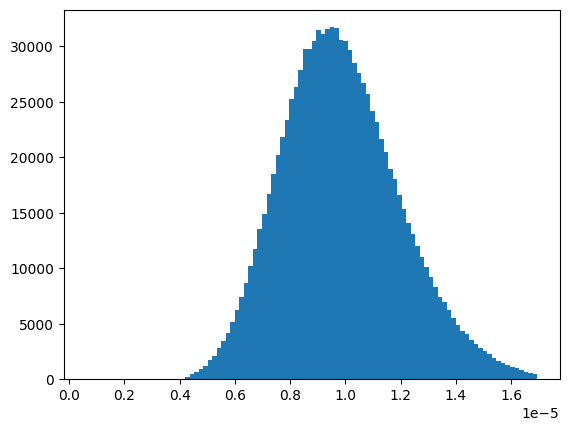

In [12]:
gal = galaxy[523889]
h = gal.header.HubbleParam
plt.hist(gal.sn.part4['GFM_InitialMass']/h, bins=100);
print(1E10*np.median(gal.sn.part4['GFM_InitialMass'])/h)

In [13]:
def get_is_star_in_SN(gal, Lz_sel=False):
    pos = gal.sn.part4['GalacticCoordinatesPhys']
    vel = gal.sn.part4['GalacticVelocitiesPhys']

    R = np.linalg.norm(pos[:,:2], axis=1)
    sphi = pos[:,1]/R
    cphi = pos[:,0]/R
    vphi = -sphi*vel[:,0] + cphi*vel[:,1]

    Lz = R * vphi
    Lzsun = 8 * 220
    if Lz_sel:
        in_SN = np.logical_and(np.abs(Lz/Lzsun-1) < 0.1, np.abs(pos[:,2] < 3))
    else:
        in_SN = np.logical_and(R < 20, np.abs(pos[:,2] < 3))
    
    is_star = gal.sn.part4['GFM_StellarFormationTime'] > 0
    is_star_in_SN = np.logical_and(is_star, in_SN)
    
    return is_star_in_SN
    
def get_metals(gal):
    Z = gal.sn.part4['GFM_Metallicity'] / GFM_SOLAR_METALLICITY
    logZ = np.log10(Z)

    FeH = gal.sn.part4['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)

    MgH = gal.sn.part4['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    MgFe = MgH/FeH
    logMgFe = np.log10(MgFe)
    
    return Z, FeH, MgH, MgFe
    

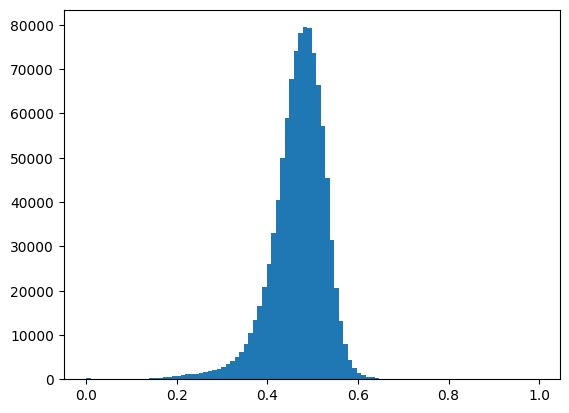

In [14]:
FeIa = galaxy[523889].sn.part4['GFM_MetalsTagged'][:,4]
FeII = galaxy[523889].sn.part4['GFM_MetalsTagged'][:,5]

plt.hist(FeIa/(FeIa+FeII), bins=100);

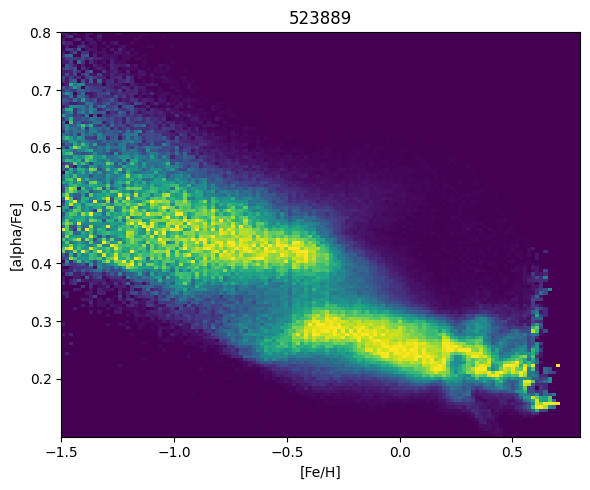

In [33]:
Nx = 128
Ny = 128

vmax = None
vmin = None

# xbins = np.linspace(-1.5, 0.2, Nx+1)
# ybins = np.linspace(0.4, 0.9, Ny+1)
xbins = np.linspace(-1.5, 0.8, Nx+1)
ybins = np.linspace(0.1, 0.8, Ny+1)

dx = (xbins[-1] - xbins[0]) / Nx
dy = (ybins[-1] - ybins[0]) / Ny

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# for i,subID in enumerate(galaxy.keys()):
if True:
    subID = 523889
    gal = galaxy[subID]
    # ax = axs.ravel()[i]
    
    is_star_in_SN = get_is_star_in_SN(gal)
    Z, FeH, MgH, MgFe = get_metals(gal)
    
    FeHnoIa = FeH - gal.sn.part4['GFM_MetalsTagged'][:,4]/GFM_SOLAR_ABUNDANCE_IRON
    frac = FeHnoIa/(FeH + FeHnoIa)
    # print(np.median(frac), np.median(FeH), np.median(FeHnoIa))
    MgFenoIa = MgH / FeHnoIa
    
    x = np.log10(FeH[is_star_in_SN])
    y = np.log10(MgFe[is_star_in_SN])
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                         statistic='sum', bins=[xbins, ybins])
    
    mbin /= dx * dy
    downstairs = np.max(mbin, axis=1)
    downstairs[downstairs==0.0] = 1e-20
    mbin = (mbin.T / downstairs).T
    
    im = ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],)
             #norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

    # print(im.get_clim())
    
    ax.set_aspect('auto')
    ax.set(xlabel='[Fe/H]', ylabel='[alpha/Fe]')
    ax.set(title=str(subID))

fig.tight_layout()

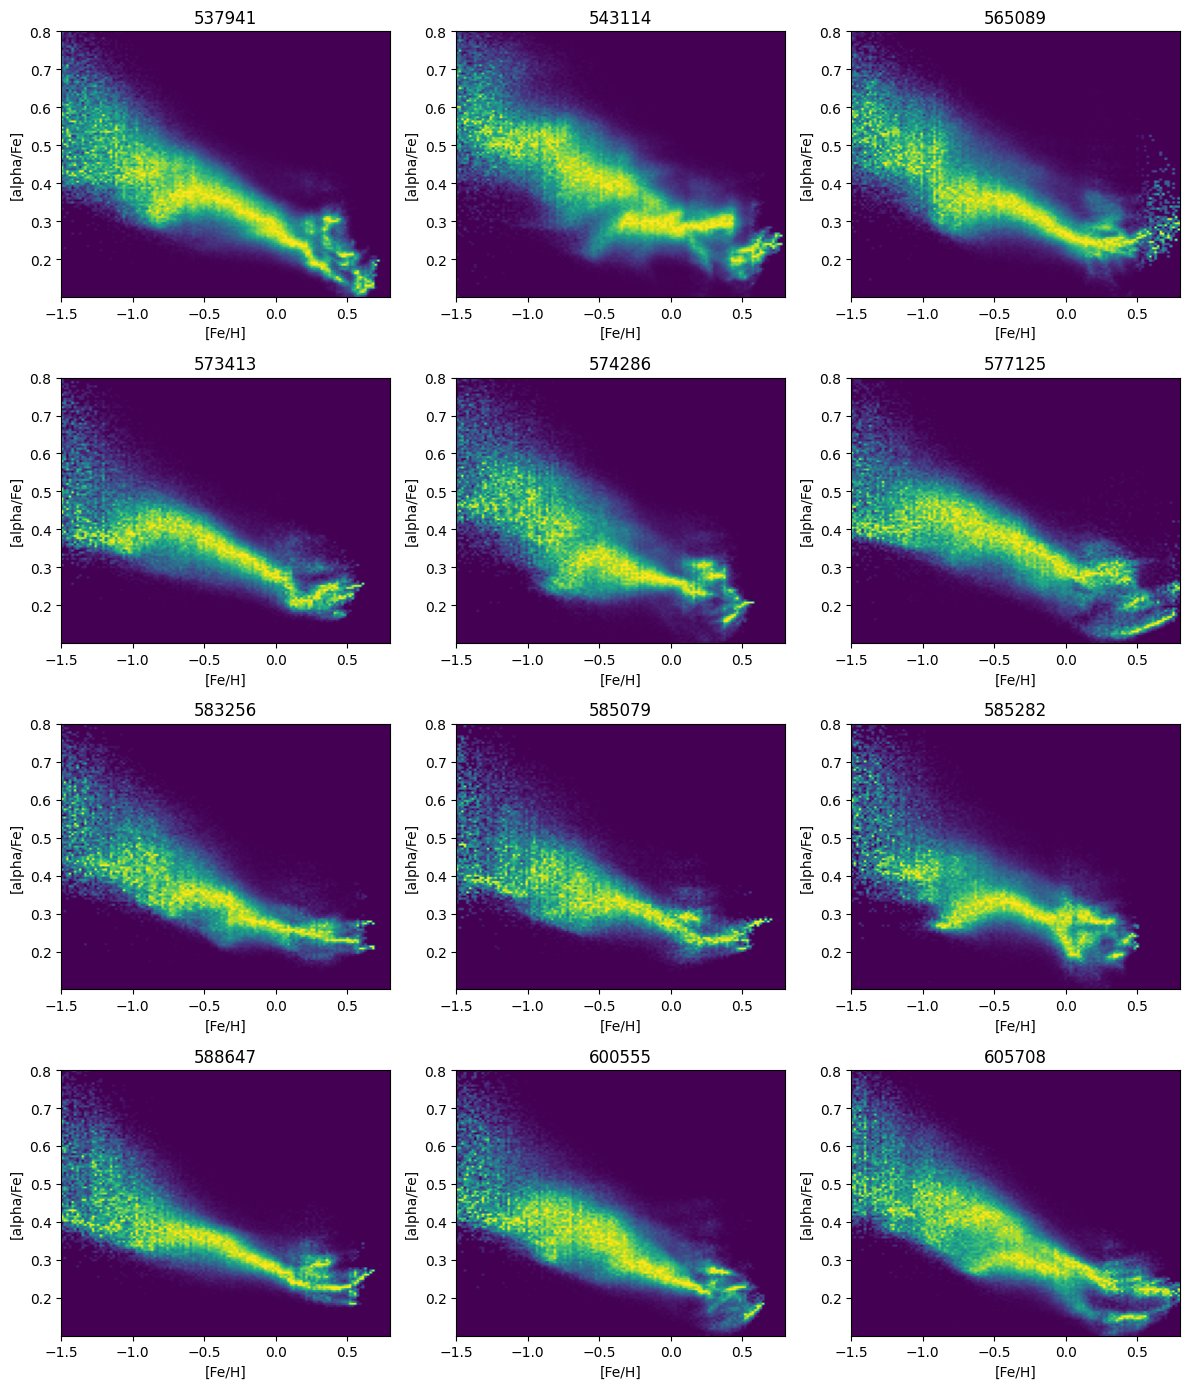

In [36]:
Nx = 128
Ny = 128

vmax = None
vmin = None

# xbins = np.linspace(-1.5, 0.2, Nx+1)
# ybins = np.linspace(0.4, 0.9, Ny+1)
xbins = np.linspace(-1.5, 0.8, Nx+1)
ybins = np.linspace(0.1, 0.8, Ny+1)

dx = (xbins[-1] - xbins[0]) / Nx
dy = (ybins[-1] - ybins[0]) / Ny

fig, axs = plt.subplots(4, 3, figsize=(12, 14))

i = 0
for subID in galaxy.keys():
    if subID == 523889:
        continue
    gal = galaxy[subID]
    ax = axs.ravel()[i]
    
    is_star_in_SN = get_is_star_in_SN(gal)
    Z, FeH, MgH, MgFe = get_metals(gal)
    
    FeHnoIa = FeH - gal.sn.part4['GFM_MetalsTagged'][:,4]/GFM_SOLAR_ABUNDANCE_IRON
    frac = FeHnoIa/(FeH + FeHnoIa)
    # print(np.median(frac), np.median(FeH), np.median(FeHnoIa))
    MgFenoIa = MgH / FeHnoIa
    
    x = np.log10(FeH[is_star_in_SN])
    y = np.log10(MgFe[is_star_in_SN])
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                         statistic='sum', bins=[xbins, ybins])
    
    mbin /= dx * dy
    downstairs = np.max(mbin, axis=1)
    downstairs[downstairs==0.0] = 1e-20
    mbin = (mbin.T / downstairs).T
    
    im = ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],)
             #norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

    # print(im.get_clim())
    
    ax.set_aspect('auto')
    ax.set(xlabel='[Fe/H]', ylabel='[alpha/Fe]')
    ax.set(title=str(subID))
    
    i += 1

fig.tight_layout()

/tmp/ipykernel_1756420/583213760.py:32: RuntimeWarning: invalid value encountered in divide
  mbin = (mbin.T / np.max(mbin, axis=1)).T
/tmp/ipykernel_1756420/583213760.py:39: RuntimeWarning: invalid value encountered in divide
  mbin = (mbin.T / np.max(mbin, axis=1)).T


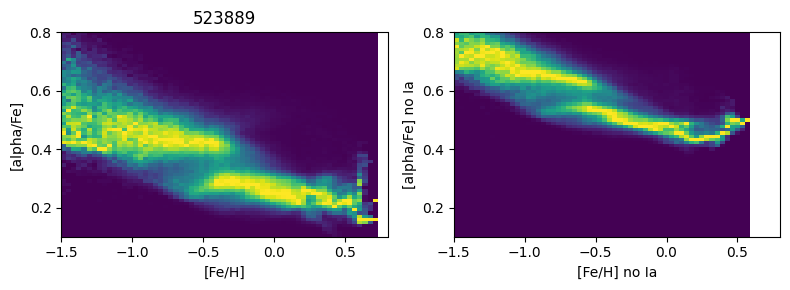

In [16]:
Nx = 64
Ny = 64

vmax = None
vmin = None

xbins = np.linspace(-1.5, 0.8, Nx+1)
ybins = np.linspace(0.1, 0.8, Ny+1)

dx = (xbins[-1] - xbins[0]) / Nx
dy = (ybins[-1] - ybins[0]) / Ny

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# for i,subID in enumerate(tqdm(galaxy.keys())):
if True:
    gal = galaxy[523889]
    
    is_star_in_SN = get_is_star_in_SN(gal)
    Z, FeH, MgH, MgFe = get_metals(gal)
    
    FeHnoIa = FeH - gal.sn.part4['GFM_MetalsTagged'][:,4]/GFM_SOLAR_ABUNDANCE_IRON
    # frac = FeHnoIa/(FeH + FeHnoIa)
    # print(np.median(frac), np.median(FeH), np.median(FeHnoIa))
    MgFenoIa = MgH / FeHnoIa
    
    x = np.log10(FeH[is_star_in_SN])
    y = np.log10(MgFe[is_star_in_SN])
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                         statistic='sum', bins=[xbins, ybins])
    mbin = (mbin.T / np.max(mbin, axis=1)).T
    im = ax[0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
    
    x = np.log10(FeHnoIa[is_star_in_SN])
    y = np.log10(MgFenoIa[is_star_in_SN])
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                         statistic='sum', bins=[xbins, ybins])
    mbin = (mbin.T / np.max(mbin, axis=1)).T
    im = ax[1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])

    ax[0].set_aspect('auto')
    ax[1].set_aspect('auto')
    
    ax[0].set(xlabel='[Fe/H]', ylabel='[alpha/Fe]')
    ax[1].set(xlabel='[Fe/H] no Ia', ylabel='[alpha/Fe] no Ia')
    ax[0].set(title=str(gal.subID))

fig.tight_layout()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.80it/s]


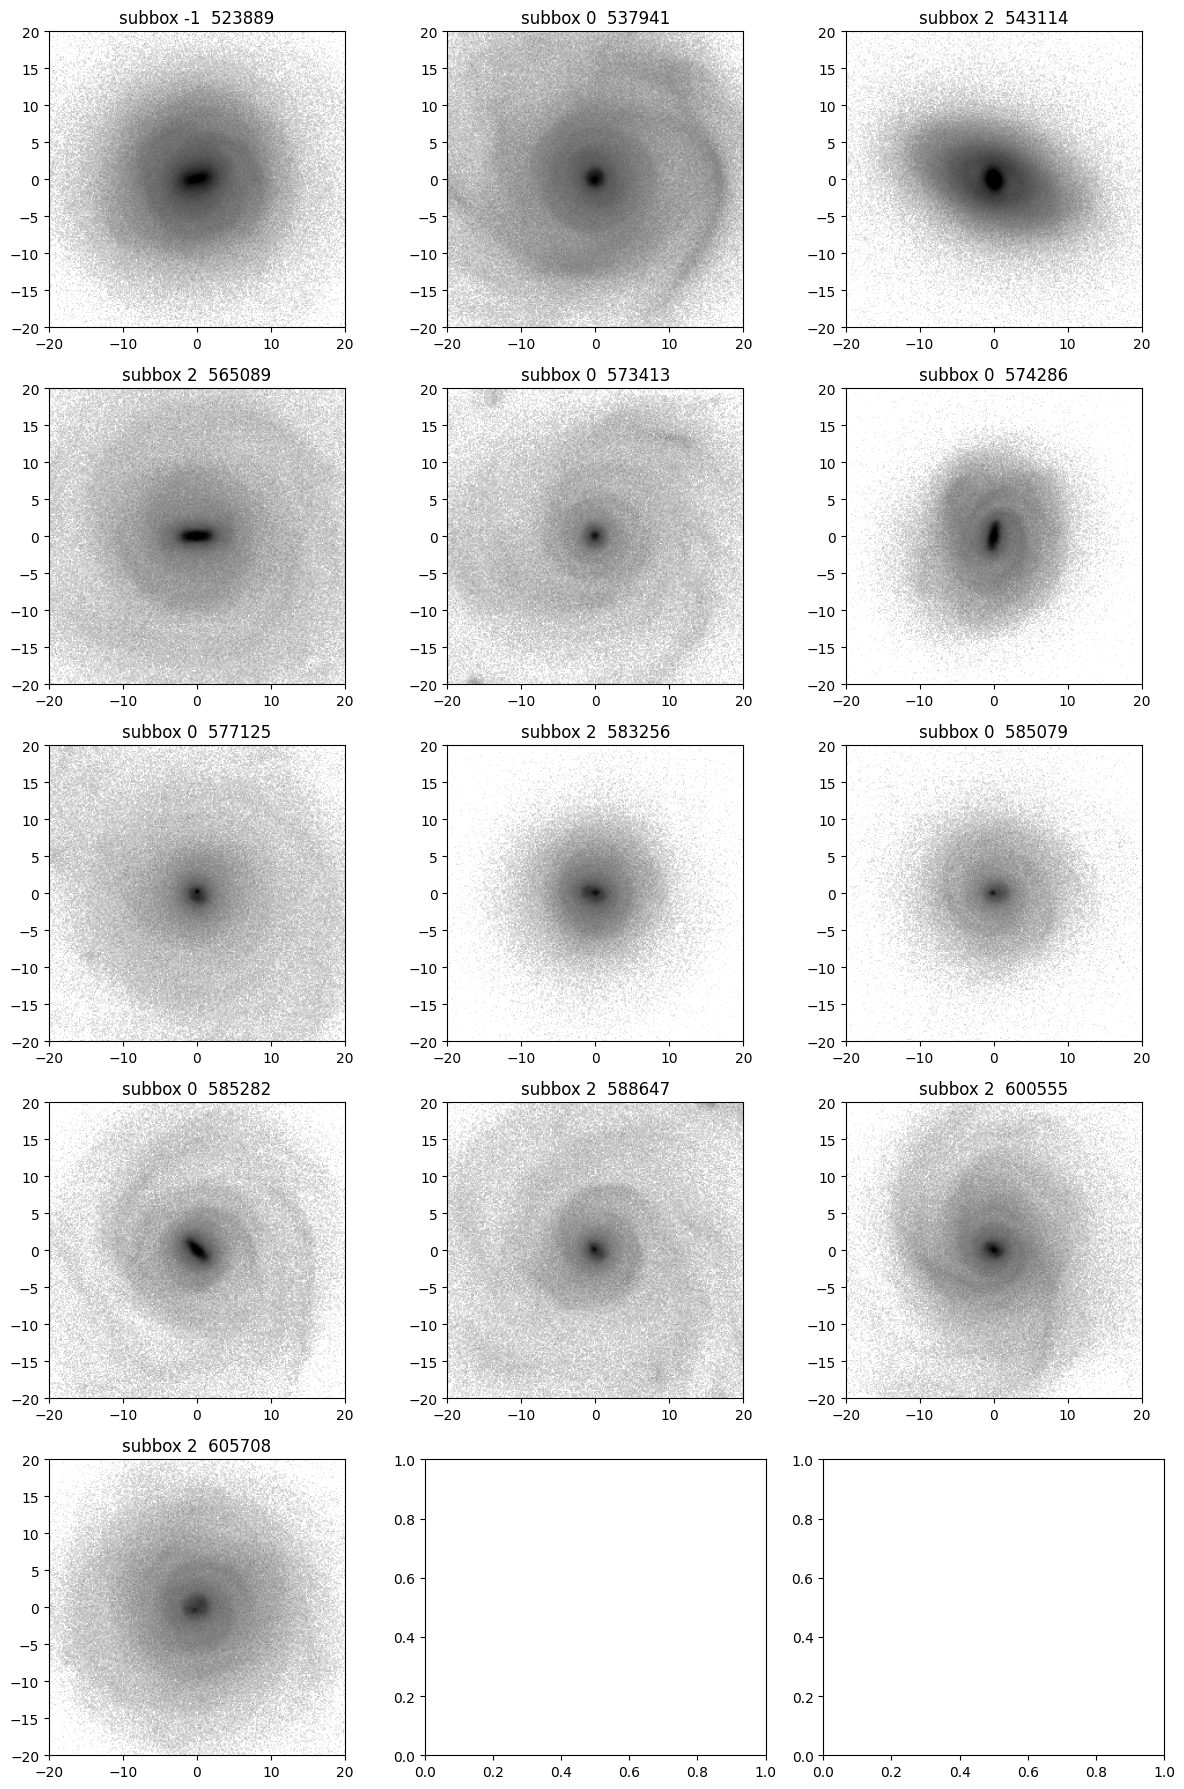

In [17]:
L = 40
nres = 256
vmax = 2E-1
vmin = 0.5E-4
cmap = 'Greys'

fig, axs = plt.subplots(5, 3, figsize=(12, 18))

for i,subID in enumerate(tqdm(galaxy.keys())):
    gal = galaxy[subID]
    # print(i)
    x = gal.sn.part4['GalacticCoordinatesPhys'][:,0]
    y = gal.sn.part4['GalacticCoordinatesPhys'][:,1]
    z = gal.sn.part4['GalacticCoordinatesPhys'][:,2]
    m = gal.sn.part4['Masses'] / gal.header.HubbleParam
    
    # k = galaxy[snapnum].CenterOfMass.k
    # theta = galaxy[snapnum].CenterOfMass.theta
    
    key = np.abs(z) < L/2.
    
    xbins = np.linspace(-L/2., L/2., nres+1)
    ybins = np.linspace(-L/2., L/2., nres+1)
    
    dx = L / nres
    dy = L / nres
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x[key], y[key], m[key], 
                                                     statistic='sum', bins=[xbins, ybins])
    mbin /= dx*dy
    
    ax = axs.ravel()[i]
    ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
               norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    
    # title = str(snapnum) + ' T=' + str(round(get_time(galaxy[snapnum].header.Time), 3))
    ax.set(aspect='equal', xlim=(x_edge[0], x_edge[-1]), ylim=(y_edge[0], y_edge[-1]))
    
    subbox = int(subbox_memb[halo['GroupFirstSub']==subID])
    ax.set(title='subbox '+str(subbox) + '  ' + str(subID))

fig.tight_layout()

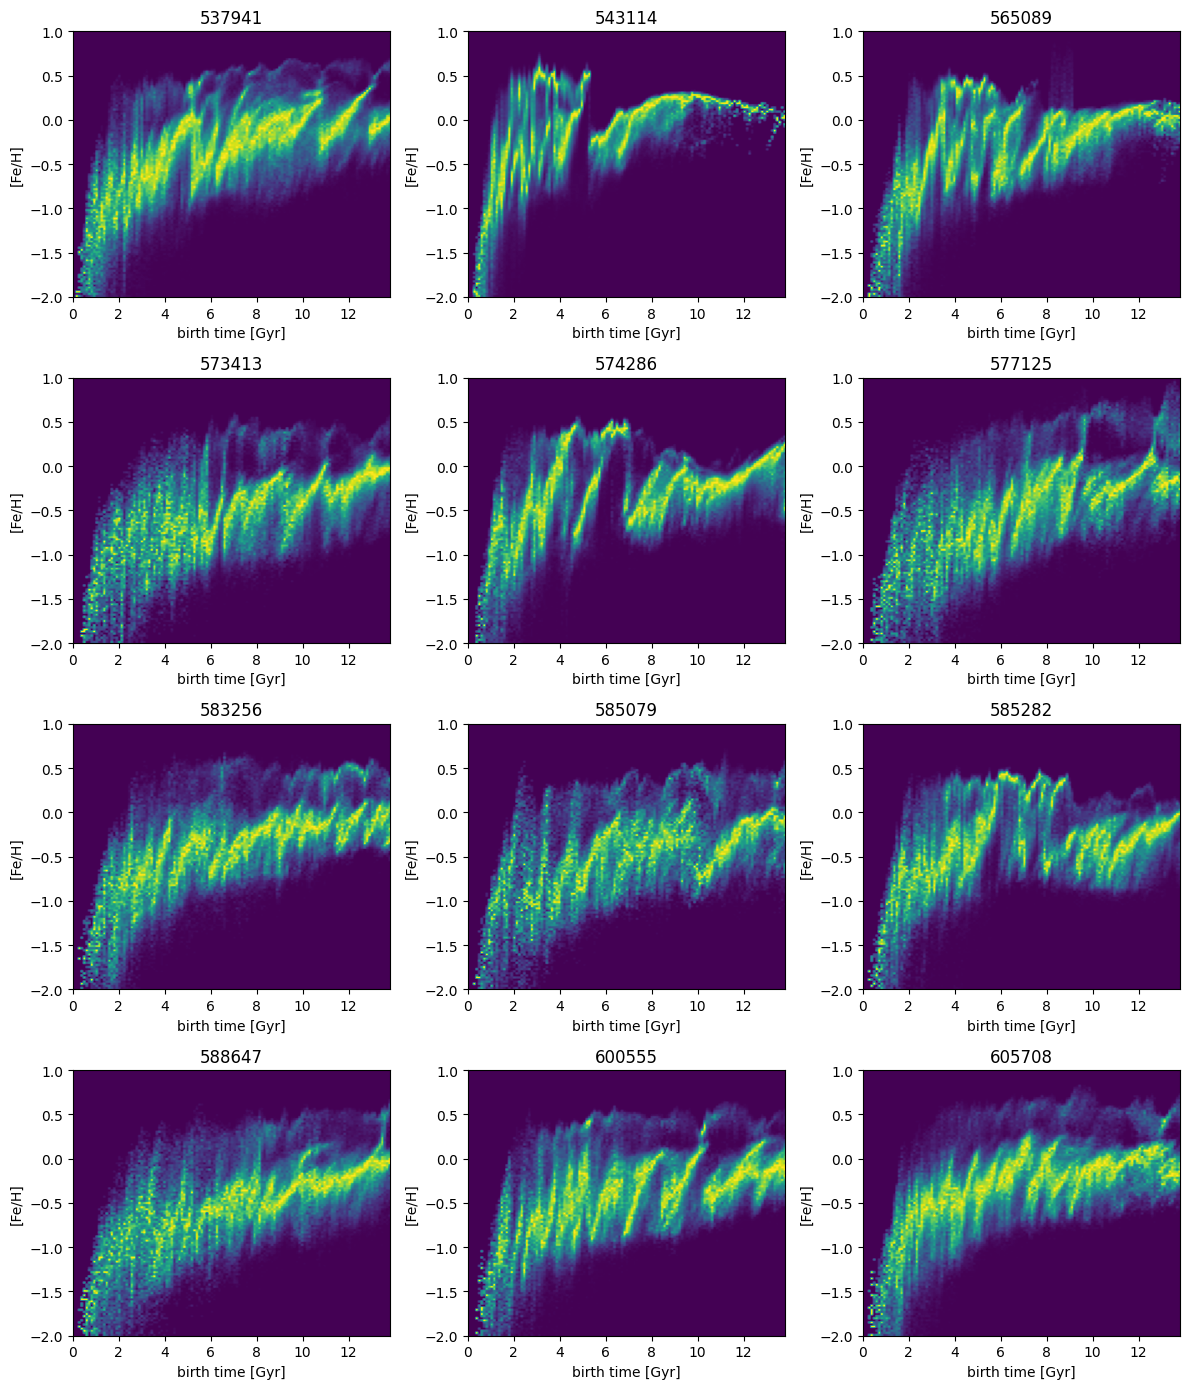

In [41]:
xbins = np.linspace(0, get_time(1), 128)
ybins = np.linspace(-2, 1, 128)

fig, axs = plt.subplots(4, 3, figsize=(12, 14))

i = 0
for subID in galaxy.keys():
    if subID == 523889:
        continue
    gal = galaxy[subID]
    ax = axs.ravel()[i]
    
    is_star_in_SN = get_is_star_in_SN(gal)
    Z, FeH, MgH, MgFe = get_metals(gal)
    t_born = gal.sn.part4['FormationTimeGyr']
    
    aveFe, _, _ = binned_statistic(t_born[is_star_in_SN], FeH[is_star_in_SN], bins=xbins)
    aveage, _, _ = binned_statistic(t_born[is_star_in_SN], t_born[is_star_in_SN], bins=xbins)
    logaveFe = np.log10(aveFe)
    
    x = t_born[is_star_in_SN]
    y = np.log10(FeH[is_star_in_SN])
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                         statistic='sum', bins=[xbins, ybins])
    # mbin /= dx * dy
    den = np.max(mbin, axis=1)
    den[den == 0] = 1e-20
    mbin = (mbin.T / den).T
    
    im = ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],)
             #norm=mpl.colors.LogNorm())

    ax.set_aspect('auto')
    ax.set(xlabel='birth time [Gyr]', ylabel='[Fe/H]', aspect='auto', 
           ylim=(y_edge[0], y_edge[-1]), xlim=(x_edge[0], x_edge[-1]))
    # ax.plot(aveage, logaveFe, c='r')
    
    subbox = int(subbox_memb[halo['GroupFirstSub']==subID])
    # ax.set(title='subbox '+str(subbox) + '  ' + str(subID))
    ax.set(title=str(subID))
    
    i += 1

fig.tight_layout()

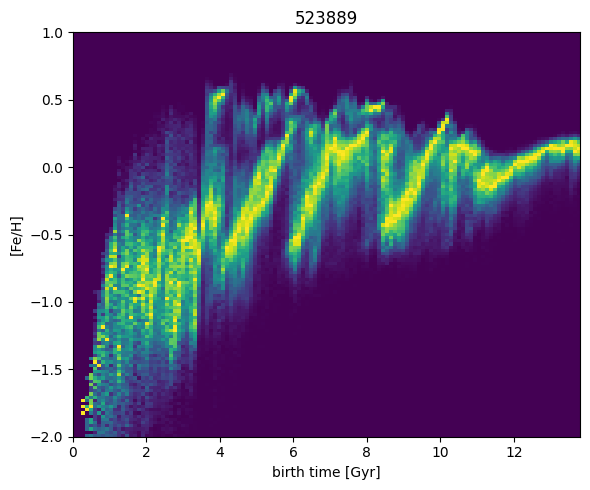

In [43]:
xbins = np.linspace(0, get_time(1), 128)
ybins = np.linspace(-2, 1, 128)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

i = 0
# for subID in galaxy.keys():
    # if subID == 523889:
        # continue
if True:
    subID = 523889
    gal = galaxy[subID]
    
    is_star_in_SN = get_is_star_in_SN(gal)
    Z, FeH, MgH, MgFe = get_metals(gal)
    t_born = gal.sn.part4['FormationTimeGyr']
    
    aveFe, _, _ = binned_statistic(t_born[is_star_in_SN], FeH[is_star_in_SN], bins=xbins)
    aveage, _, _ = binned_statistic(t_born[is_star_in_SN], t_born[is_star_in_SN], bins=xbins)
    logaveFe = np.log10(aveFe)
    
    x = t_born[is_star_in_SN]
    y = np.log10(FeH[is_star_in_SN])
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                         statistic='sum', bins=[xbins, ybins])
    # mbin /= dx * dy
    den = np.max(mbin, axis=1)
    den[den == 0] = 1e-20
    mbin = (mbin.T / den).T
    
    im = ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],)
             #norm=mpl.colors.LogNorm())

    ax.set_aspect('auto')
    ax.set(xlabel='birth time [Gyr]', ylabel='[Fe/H]', aspect='auto', 
           ylim=(y_edge[0], y_edge[-1]), xlim=(x_edge[0], x_edge[-1]))
    # ax.plot(aveage, logaveFe, c='r')
    
    subbox = int(subbox_memb[halo['GroupFirstSub']==subID])
    # ax.set(title='subbox '+str(subbox) + '  ' + str(subID))
    ax.set(title=str(subID))
    
    i += 1

fig.tight_layout()

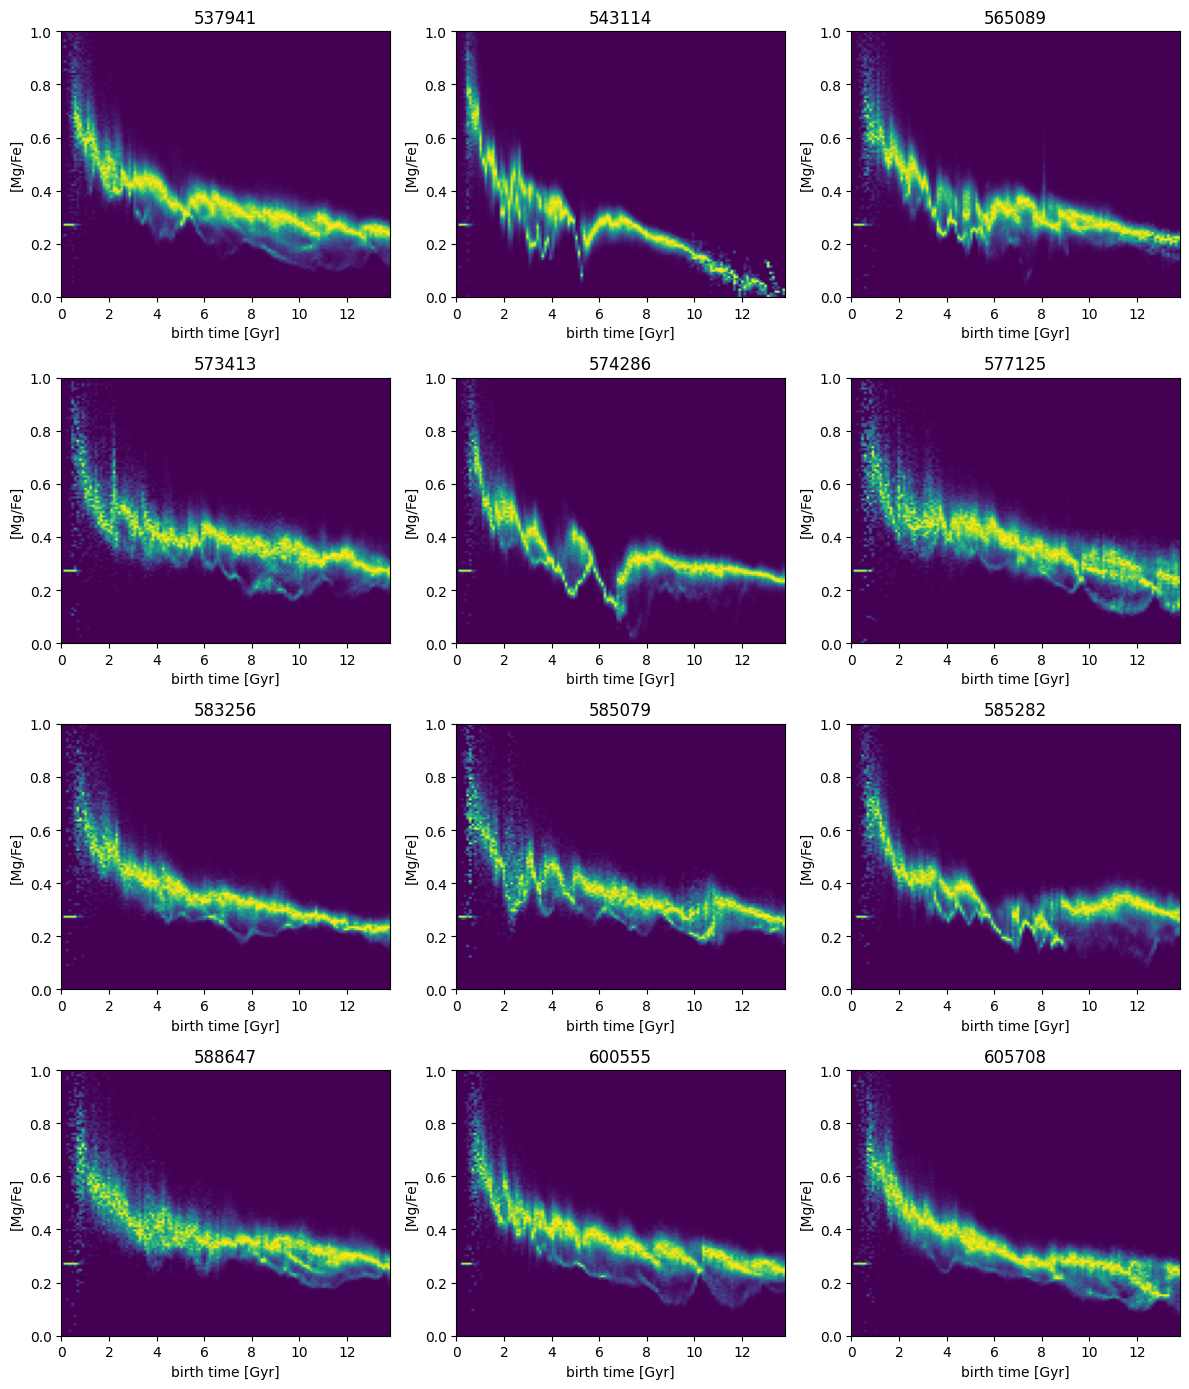

In [44]:
xbins = np.linspace(0, get_time(1), 128)
ybins = np.linspace(0, 1, 128)

fig, axs = plt.subplots(4, 3, figsize=(12, 14))

i = 0
for subID in galaxy.keys():
    if subID == 523889:
        continue
    gal = galaxy[subID]
    ax = axs.ravel()[i]
    
    is_star_in_SN = get_is_star_in_SN(gal)
    Z, FeH, MgH, MgFe = get_metals(gal)
    t_born = gal.sn.part4['FormationTimeGyr']
    
    aveMgFe, _, _ = binned_statistic(t_born[is_star_in_SN], MgFe[is_star_in_SN], bins=xbins)
    aveage, _, _ = binned_statistic(t_born[is_star_in_SN], t_born[is_star_in_SN], bins=xbins)
    logaveMgFe = np.log10(aveMgFe)
    
    x = t_born[is_star_in_SN]
    y = np.log10(MgFe[is_star_in_SN])
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                         statistic='sum', bins=[xbins, ybins])
    
    den = np.max(mbin, axis=1)
    den[den == 0] = 1e-20
    mbin = (mbin.T / den).T
    
    im = ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],)
             #norm=mpl.colors.LogNorm())

    ax.set_aspect('auto')
    ax.set(xlabel='birth time [Gyr]', ylabel='[Mg/Fe]', aspect='auto', 
           ylim=(y_edge[0], y_edge[-1]), xlim=(x_edge[0], x_edge[-1]))
    # ax.plot(aveage, logaveMgFe, c='r')
    
    subbox = int(subbox_memb[halo['GroupFirstSub']==subID])
    ax.set(title=str(subID))
    
    i += 1

fig.tight_layout()

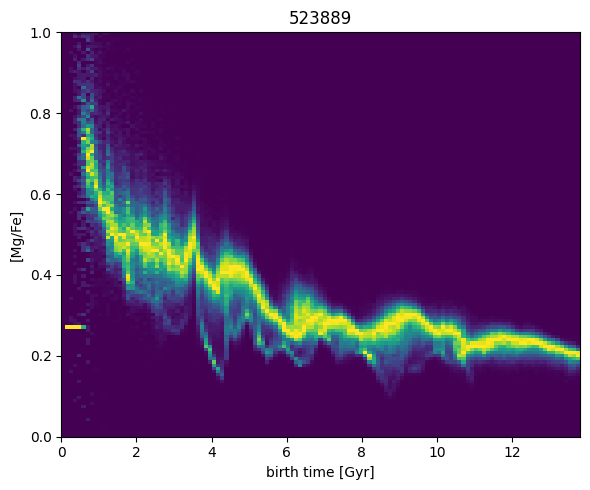

In [45]:
xbins = np.linspace(0, get_time(1), 128)
ybins = np.linspace(0, 1, 128)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

if True:
    subID = 523889
    gal = galaxy[subID]
    
    is_star_in_SN = get_is_star_in_SN(gal)
    Z, FeH, MgH, MgFe = get_metals(gal)
    t_born = gal.sn.part4['FormationTimeGyr']
    
    aveMgFe, _, _ = binned_statistic(t_born[is_star_in_SN], MgFe[is_star_in_SN], bins=xbins)
    aveage, _, _ = binned_statistic(t_born[is_star_in_SN], t_born[is_star_in_SN], bins=xbins)
    logaveMgFe = np.log10(aveMgFe)
    
    x = t_born[is_star_in_SN]
    y = np.log10(MgFe[is_star_in_SN])
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                         statistic='sum', bins=[xbins, ybins])
    
    den = np.max(mbin, axis=1)
    den[den == 0] = 1e-20
    mbin = (mbin.T / den).T
    
    im = ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],)
             #norm=mpl.colors.LogNorm())

    ax.set_aspect('auto')
    ax.set(xlabel='birth time [Gyr]', ylabel='[Mg/Fe]', aspect='auto', 
           ylim=(y_edge[0], y_edge[-1]), xlim=(x_edge[0], x_edge[-1]))
    # ax.plot(aveage, logaveMgFe, c='r')
    
    subbox = int(subbox_memb[halo['GroupFirstSub']==subID])
    ax.set(title=str(subID))
    
    i += 1

fig.tight_layout()

  0%|                                                                                                                                 | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_1756420/1945257647.py:25: RuntimeWarning: invalid value encountered in divide
  mbin = (mbin.T / np.max(mbin, axis=1)).T
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.37it/s]


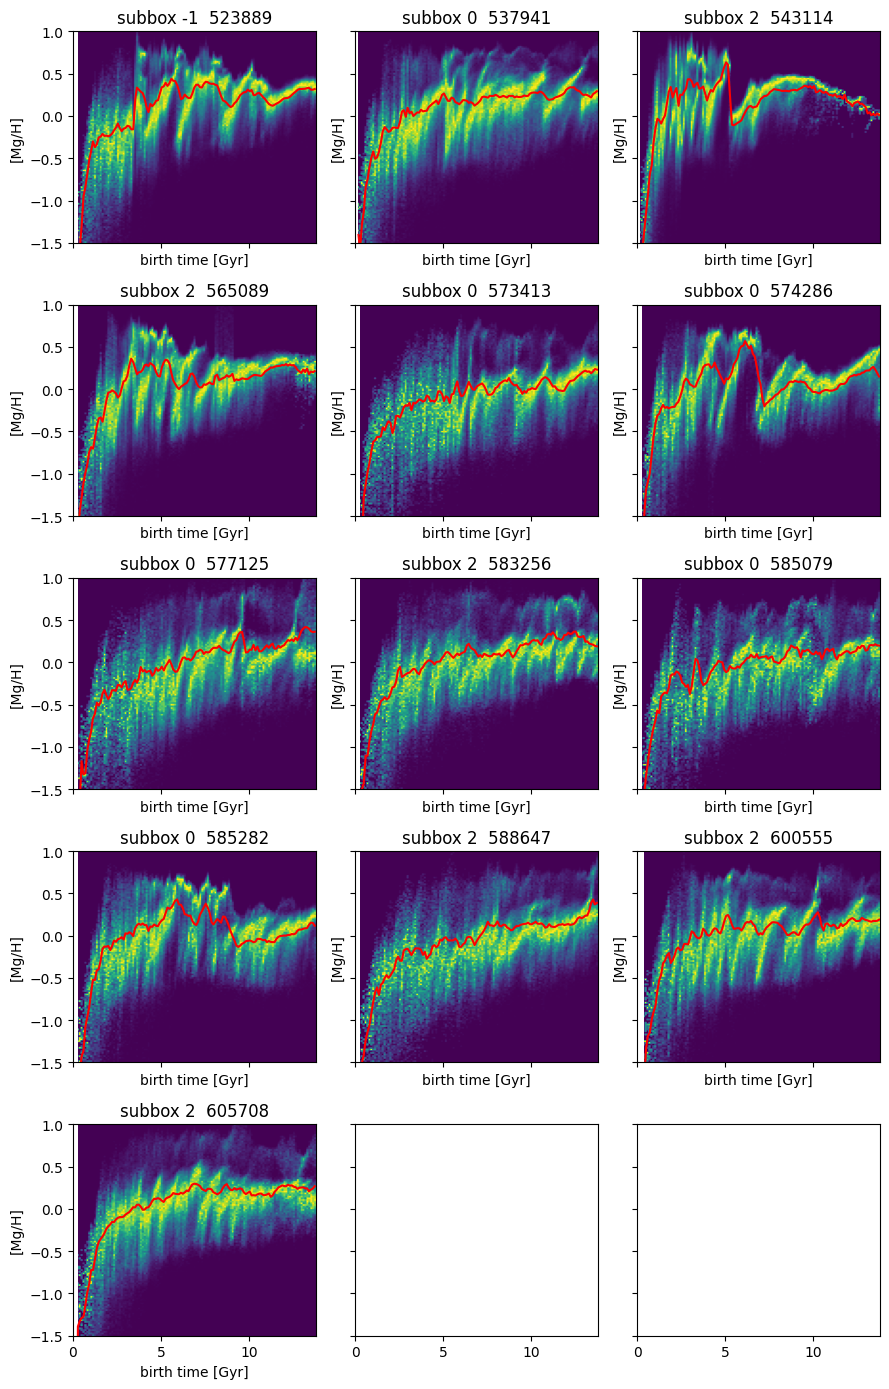

In [20]:
xbins = np.linspace(0, get_time(1), 128)
ybins = np.linspace(-1.5, 1, 128)

fig, axs = plt.subplots(5, 3, figsize=(9, 14), sharex=True, sharey=True)

for i,subID in enumerate(tqdm(galaxy.keys())):
    gal = galaxy[subID]
    ax = axs.ravel()[i]
    
    is_star_in_SN = get_is_star_in_SN(gal)
    Z, FeH, MgH, MgFe = get_metals(gal)
    t_born = gal.sn.part4['FormationTimeGyr']
    
    aveMgH, _, _ = binned_statistic(t_born[is_star_in_SN], MgH[is_star_in_SN], bins=xbins)
    aveage, _, _ = binned_statistic(t_born[is_star_in_SN], t_born[is_star_in_SN], bins=xbins)
    logaveMgFe = np.log10(aveMgH)
    
    x = t_born[is_star_in_SN]
    y = np.log10(MgH[is_star_in_SN])
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                         statistic='sum', bins=[xbins, ybins])

    
    mbin = (mbin.T / np.max(mbin, axis=1)).T
    
    im = ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],)
             #norm=mpl.colors.LogNorm())

    ax.set_aspect('auto')
    ax.set(xlabel='birth time [Gyr]', ylabel='[Mg/H]', aspect='auto', 
           ylim=(y_edge[0], y_edge[-1]), xlim=(x_edge[0], x_edge[-1]))
    ax.plot(aveage, logaveMgFe, c='r')
    
    subbox = int(subbox_memb[halo['GroupFirstSub']==subID])
    ax.set(title='subbox '+str(subbox) + '  ' + str(subID))

fig.tight_layout()

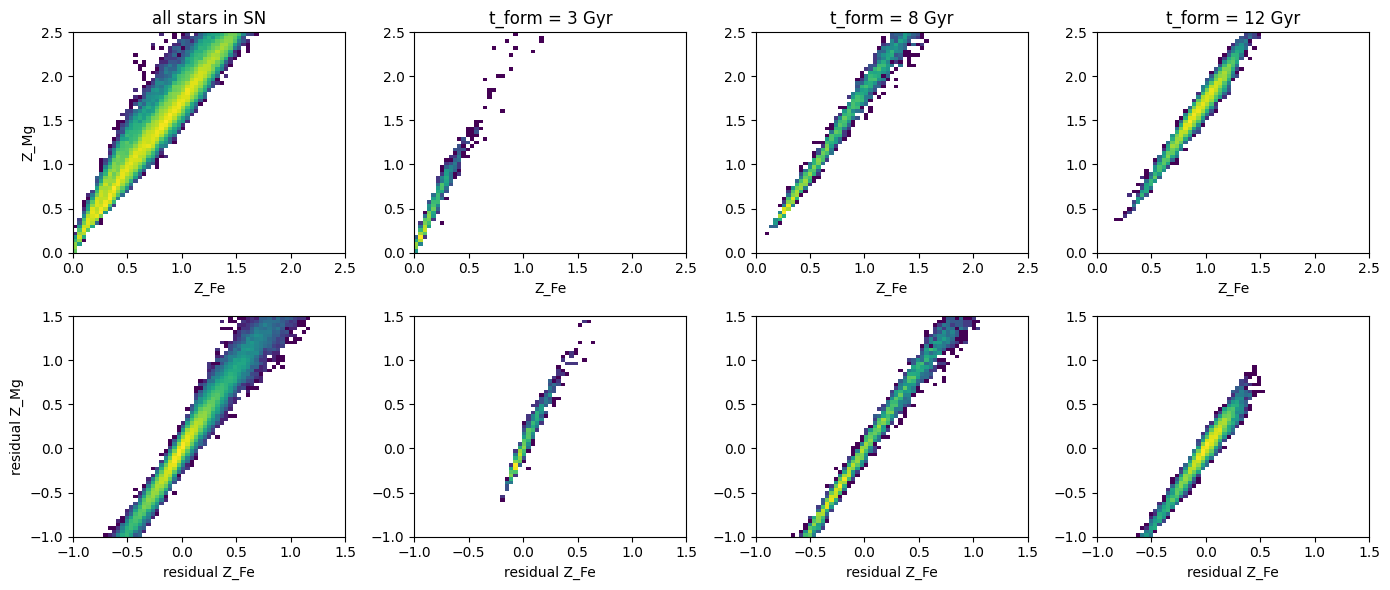

In [21]:
gal = galaxy[523889]

from scipy.interpolate import interp1d

in_SN = get_is_star_in_SN(gal, Lz_sel=True)
Z, FeH, MgH, MgFe = get_metals(gal)
t_form = gal.sn.part4['FormationTimeGyr']

age_bins  = np.linspace(0, 13.5, 64)
FeH_bins = np.linspace(0, 2.5, 64)
MgH_bins = np.linspace(0, 2.5, 64)
resid_FeH_bins = np.linspace(-1, 1.5, 64)
resid_MgH_bins = np.linspace(-1, 1.5, 64)

aveFeH, _, _ = binned_statistic(t_form[in_SN], FeH[in_SN], bins=age_bins, statistic='median')
aveMgH, _, _ = binned_statistic(t_form[in_SN], MgH[in_SN], bins=age_bins, statistic='median')
aveage, _, _ = binned_statistic(t_form[in_SN], t_form[in_SN], bins=age_bins, statistic='median')
# aveFe = np.log10(aveFe)
# aveMgFe = np.log10(aveMgFe)

aveFeH_interp = interp1d(aveage, aveFeH, bounds_error=False, fill_value='extrapolate')
aveMgH_interp = interp1d(aveage, aveMgH, bounds_error=False, fill_value='extrapolate')

aveFeH_pred = aveFeH_interp(t_form)
aveMgH_pred = aveMgH_interp(t_form)

fig, ax = plt.subplots(2, 4, figsize=(14, 6))

resid_FeH = FeH - aveFeH_pred
resid_MgH = MgH - aveMgH_pred

mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[in_SN], 
                                              MgH[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][0].set(aspect='auto', ylabel='Z_Mg', xlabel='Z_Fe')
ax[0][0].set_title('all stars in SN')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[in_SN], 
                                              resid_MgH[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][0].set(aspect='auto', ylabel='residual Z_Mg', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 2.5, t_form < 3.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[key], 
                                              MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][1].set(aspect='auto', xlabel='Z_Fe')
ax[0][1].set_title('t_form = 3 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][1].set(aspect='auto', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[key], 
                                              MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][2].set(aspect='auto', xlabel='Z_Fe')
ax[0][2].set_title('t_form = 8 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][2].set(aspect='auto', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[key], 
                                              MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][3].set(aspect='auto', xlabel='Z_Fe')
ax[0][3].set_title('t_form = 12 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][3].set(aspect='auto', xlabel='residual Z_Fe')

fig.tight_layout()


[Text(0, 0.5, 'Z_Mg')]

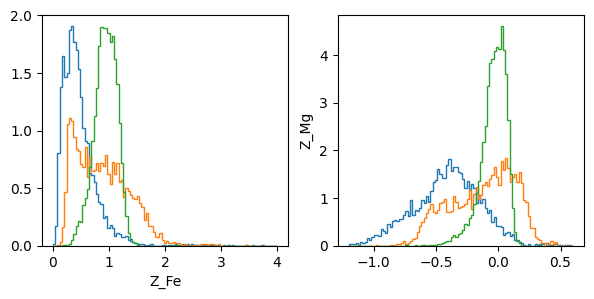

In [22]:
gal = galaxy[523889]

density = True

bins = np.linspace(0, 4, 100)
logbins = np.linspace(-1.2, 0.6, 100)

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

in_SN = get_is_star_in_SN(gal, Lz_sel=True)
Z, FeH, MgH, MgFe = get_metals(gal)
logFeH = np.log10(FeH)
logMgH = np.log10(MgH)
logMgFe = np.log10(MgFe)
t_form = gal.sn.part4['FormationTimeGyr']

key = np.logical_and(t_form > 4.5, t_form < 5.5)
key = np.logical_and(key, in_SN)
ax[0].hist(FeH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logFeH[key], histtype='step', density=density, bins=logbins);

key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(key, in_SN)
ax[0].hist(FeH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logFeH[key], histtype='step', density=density, bins=logbins);

key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)
ax[0].hist(FeH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logFeH[key], histtype='step', density=density, bins=logbins);

ax[0].set(xlabel='Z_Fe')
ax[1].set(ylabel='Z_Mg')


In [23]:
gal = galaxy[523889]

t_min = 0
dt = 0.2
bin_width = 1.0

in_SN = get_is_star_in_SN(gal, Lz_sel=True)
Z, FeH, MgH, MgFe = get_metals(gal)
logFeH = np.log10(FeH)
logMgH = np.log10(MgH)
logMgFe = np.log10(MgFe)
t_form = gal.sn.part4['FormationTimeGyr']

avet_form = []
mu = []
cov = []

while t_min < 13:
    key = np.logical_and(t_form > t_min, t_form < t_min + bin_width)
    key = np.logical_and(key, in_SN)
    
    avet_form.append(np.mean(t_form[key]))
    
    data = np.transpose([logFeH[key], logMgH[key]])
    mu_, cov_ = multivariate_normal.fit(data)
    mu.append(mu_)
    cov.append(cov_)

    t_min += dt/2.

avet_form = np.array(avet_form)
mu = np.array(mu)
cov = np.array(cov)

var = np.transpose([cov[:,0,0], cov[:,1,1]])
mu_Z = 10.**(mu + var/2.)
# mu_Z = mu

Text(0, 0.5, 'mass fraction')

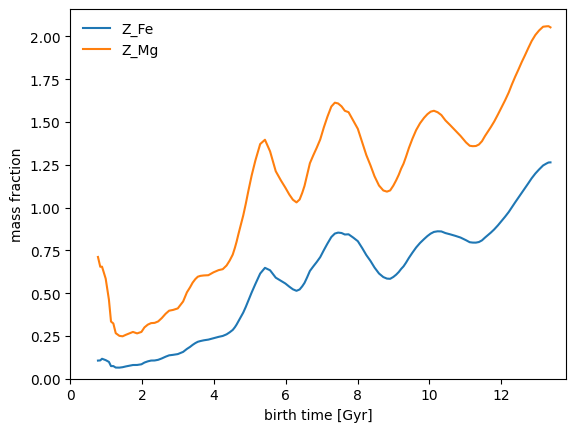

In [24]:
plt.plot(avet_form, mu_Z[:,0], label='Z_Fe')
plt.plot(avet_form, mu_Z[:,1], label='Z_Mg')
# plt.plot(avet_form, mu_Z[:,1]/mu_Z[:,0])
plt.legend(frameon=False)

plt.xlim(0, get_time(1))
plt.ylim(0, None)

plt.xlabel('birth time [Gyr]')
plt.ylabel('mass fraction')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Z_Mg/Z_Fe')

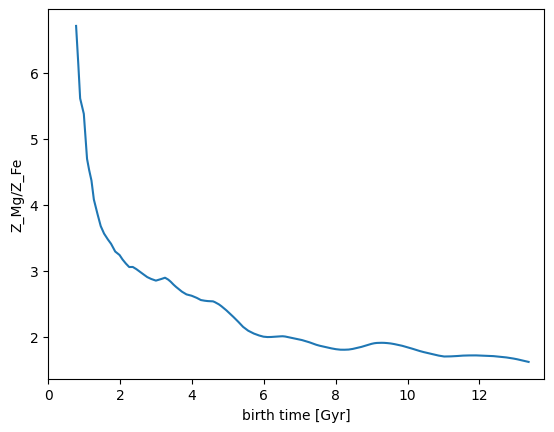

In [25]:
plt.plot(avet_form, mu_Z[:,1]/mu_Z[:,0])
plt.legend(frameon=False)

plt.xlim(0, get_time(1))
# plt.ylim(0, None)

plt.xlabel('birth time [Gyr]')
plt.ylabel('Z_Mg/Z_Fe')

(0.8, 1.1)

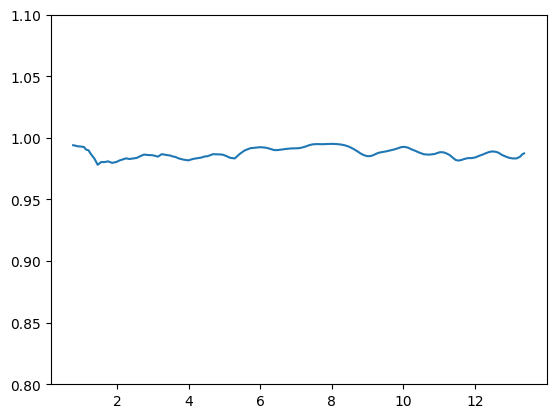

In [26]:
plt.plot(avet_form, cov[:,0,1]/np.sqrt(cov[:,0,0]*cov[:,1,1]))
plt.ylim(0.8, 1.1)
# plt.ylim(0, 1.1)